In [1]:
pip  install stellargraph

     |████████████████████████████████| 440kB 2.8MB/s 


In [3]:
pip install networkx==2.3

In [4]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [5]:
from google.colab import files
files=files.upload()



Saving movie_actor_network.csv to movie_actor_network.csv


In [6]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [7]:
edges = [tuple(x) for x in data.values.tolist()]

In [8]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [9]:
A = list(nx.connected_component_subgraphs(B))[0]

In [10]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


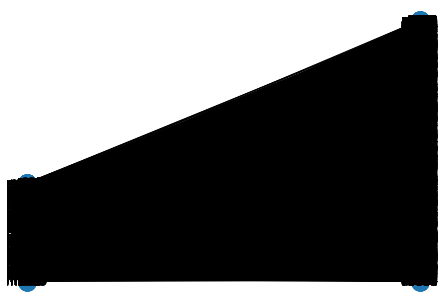

In [11]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [12]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [13]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [14]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [15]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [16]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

In [17]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    j=0
    for i in node_ids:
      if 'a' in i:
        actor_embeddings.append(node_embeddings[j])
        actor_nodes.append(i)
      if 'm' in i:
        movie_embeddings.append(node_embeddings[j])
        movie_nodes.append(i)
      j=j+1

    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


In [18]:
# for checking 
an,mn,ae,me=data_split(node_ids,node_targets,node_embeddings)
print(len(an))
print(len(ae))
print(len(mn))
print(len(me))
ae=np.array(ae)
me=np.array(me)
print(ae.shape)
print(me.shape)


3411
3411
1292
1292
(3411, 128)
(1292, 128)


In [19]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(an)# i declared actor_nodes as 'an' 

True

In [20]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(mn)

True

In [30]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    n=0
    d=0
    k=0
    cost1=0
    n=graph.number_of_nodes()
    largest_cc = max(nx.connected_components(graph), key=len)
    k=len(largest_cc)
    cost1=k/n
    cost1=cost1/number_of_clusters
    return cost1

In [27]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    count1=0
    count2=0
    cost2=0
    for i in graph.nodes():
      if 'm' in i:
        count1=count1+1
      if 'a' in i:
        count2=count2+graph.degree(i)
    #print(count1)
    #print(count2)
    cost2=count2/count1
    cost2=cost2/number_of_clusters
    return cost2

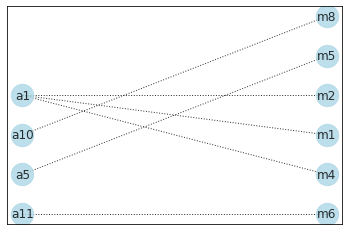

In [31]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

In [32]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

In [33]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

In [34]:
print(ae.shape)

(3411, 128)


In [35]:
from tqdm import tqdm
import random
from sklearn.cluster import KMeans
params = {'n_clusters':[3, 5, 10, 30, 50, 100, 200, 500]}
C=[]
for i in tqdm(params['n_clusters']):
  algo=KMeans(n_clusters=i).fit(ae)
  k=algo.labels_
  k=list(k)
  u=set(k)
  u=list(u)
  d1=dict(zip(an,k))
  list_of_clusters=[]
  for d in range(len(u)):
    l=[]
    for p,q in d1.items():
      if q==u[d]:
        l.append(p)
    list_of_clusters.append(l)
  l1=[]
  l2=[]
  x=0
  y=0
  print(len(list_of_clusters))
  for c in range(len(list_of_clusters)):
    G=nx.Graph()
    c1=0
    c2=0
    for a in list_of_clusters[c]:
      sub_graph=nx.ego_graph(B,a)
      G.add_nodes_from(sub_graph.nodes)
      G.add_edges_from(sub_graph.edges())
    c1=cost1(G,i)
    c2=cost2(G,i)
    l1.append(c1)
    l2.append(c2)
  x=sum(l1)
  y=sum(l2)
  C.append(x*y)
print(C)


  0%|          | 0/8 [00:00<?, ?it/s]

3


 12%|█▎        | 1/8 [00:00<00:05,  1.18it/s]

5


 25%|██▌       | 2/8 [00:02<00:05,  1.05it/s]

10


 38%|███▊      | 3/8 [00:03<00:05,  1.14s/it]

30


 50%|█████     | 4/8 [00:06<00:06,  1.69s/it]

50


 62%|██████▎   | 5/8 [00:10<00:07,  2.38s/it]

100


 75%|███████▌  | 6/8 [00:17<00:07,  3.68s/it]

200


 88%|████████▊ | 7/8 [00:28<00:06,  6.07s/it]

500


100%|██████████| 8/8 [00:54<00:00,  6.81s/it]

[3.82633714840283, 2.9028624927789037, 2.3735087785292315, 1.7364121759858486, 1.613242501177667, 1.5558355877276333, 1.7595356014891617, 1.7549167222707096]


In [43]:
clusters=[3, 5, 10, 30, 50, 100, 200, 500]
d=dict(zip(clusters,C))
k=d.values()
print(max(k))

3.82633714840283


In [ ]:
#optimal clustering algorithm


In [44]:
best_clustering_algo=KMeans(n_clusters=3).fit(ae)

In [45]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
ae_2d = trans.fit_transform(ae)

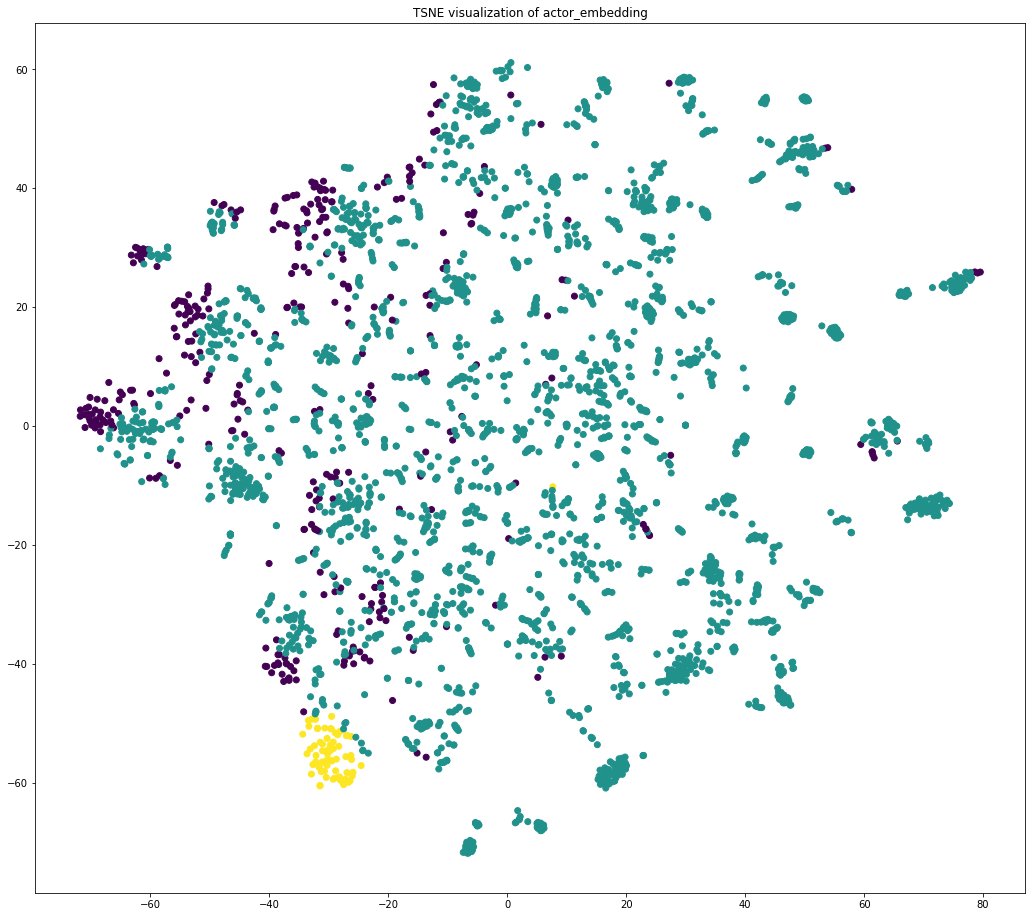

In [46]:
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(ae_2d[:,0], ae_2d[:,1], c=best_clustering_algo.labels_.astype(float))
plt.title('{} visualization of actor_embedding'.format(transform.__name__))

plt.show()

In [ ]:
   #  clustering_algorithm for movie nodes

In [47]:
from tqdm import tqdm
import random
from sklearn.cluster import KMeans
params = {'n_clusters':[3, 5, 10, 30, 50, 100, 200, 500]}
C=[]
for i in tqdm(params['n_clusters']):
  algo=KMeans(n_clusters=i).fit(me)
  k=algo.labels_
  k=list(k)
  u=set(k)
  u=list(u)
  d1=dict(zip(an,k))
  list_of_clusters=[]
  for d in range(len(u)):
    l=[]
    for p,q in d1.items():
      if q==u[d]:
        l.append(p)
    list_of_clusters.append(l)
  l1=[]
  l2=[]
  x=0
  y=0
  print(len(list_of_clusters))
  for c in range(len(list_of_clusters)):
    G=nx.Graph()
    c1=0
    c2=0
    for a in list_of_clusters[c]:
      sub_graph=nx.ego_graph(B,a)
      G.add_nodes_from(sub_graph.nodes)
      G.add_edges_from(sub_graph.edges())
    c1=cost1(G,i)
    c2=cost2(G,i)
    l1.append(c1)
    l2.append(c2)
  x=sum(l1)
  y=sum(l2)
  C.append(x*y)
print(C)

  0%|          | 0/8 [00:00<?, ?it/s]

3


 12%|█▎        | 1/8 [00:00<00:03,  1.87it/s]

5


 25%|██▌       | 2/8 [00:01<00:03,  1.75it/s]

10


 38%|███▊      | 3/8 [00:01<00:03,  1.60it/s]

30


 50%|█████     | 4/8 [00:03<00:03,  1.24it/s]

50


 62%|██████▎   | 5/8 [00:04<00:03,  1.08s/it]

100


 75%|███████▌  | 6/8 [00:07<00:03,  1.63s/it]

200


 88%|████████▊ | 7/8 [00:13<00:02,  2.70s/it]

500


100%|██████████| 8/8 [00:24<00:00,  3.03s/it]

[2.2856866310256807, 1.6538070763857793, 1.0024277953914453, 0.5215204930040669, 0.5575731084022453, 0.6081429170046565, 0.6858077082312698, 0.83711829438175]


In [48]:
clusters=[3, 5, 10, 30, 50, 100, 200, 500]
d=dict(zip(clusters,C))
k=d.values()
print('value:',max(k))

value: 2.2856866310256807


In [ ]:
#optimal clustering algorithm

In [49]:
best_clustering_algo=KMeans(n_clusters=3).fit(me)

In [50]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
me_2d = trans.fit_transform(me)

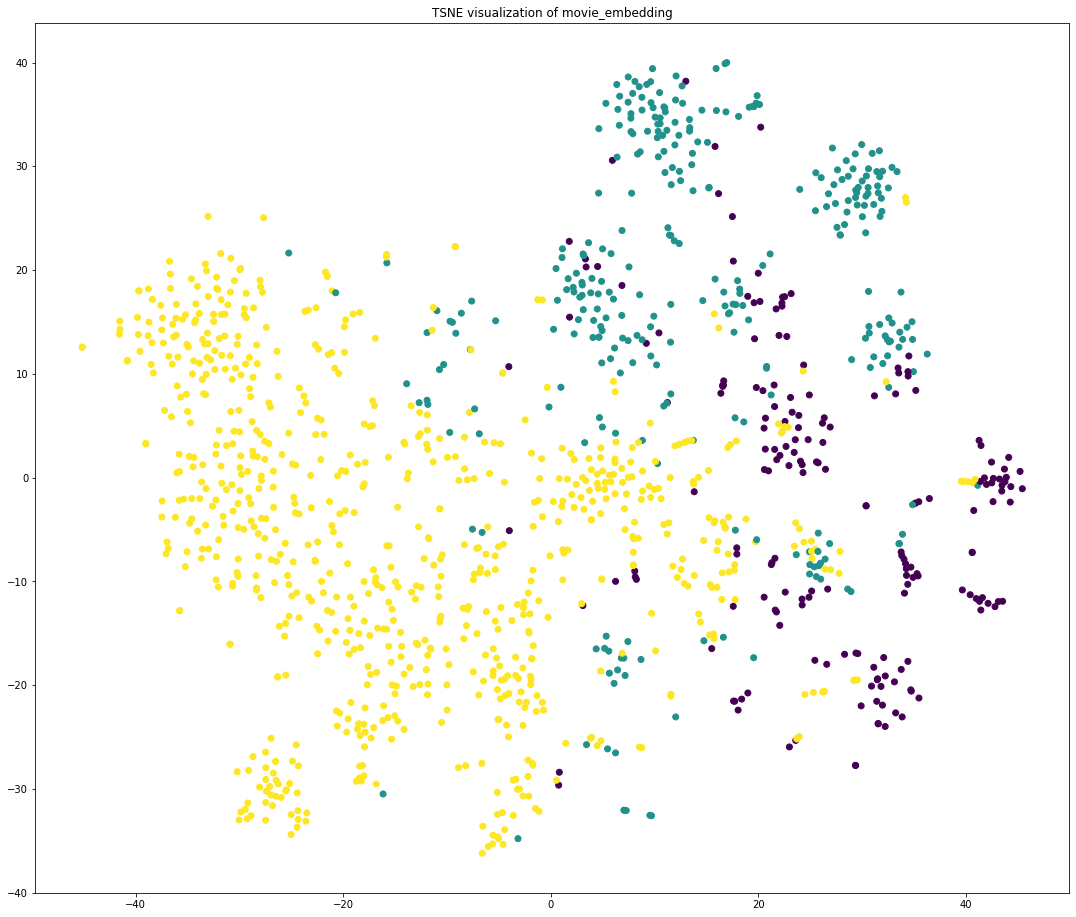

In [51]:
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(me_2d[:,0], me_2d[:,1], c=best_clustering_algo.labels_.astype(float))
plt.title('{} visualization of movie_embedding'.format(transform.__name__))

plt.show()